# Lecture 3: Matvecs and matmuls, memory hierarchy, Strassen algorithm

## Recap of the previous lectures

- Floating point arithmetics and related issues
- Stable algorithms: backward and forward stability
- Most important matrix norms: spectral and Frobenius
- Unitary matrices preserve these norms
- There are two "basic" classes of unitary matrices: Householder and Givens matrices

## Examples of peak performance

**Flops** –– floating point operations per second.

Giga = $2^{30} \approx 10^9$,  
Tera = $2^{40} \approx 10^{12}$,      
Peta = $2^{50} \approx 10^{15}$,       
Exa = $2^{60} \approx 10^{18}$ 

What is the **peak perfomance** of:

1. Modern CPU
2. Modern GPU
3. Largest supercomputer of the world? 

### Clock frequency of CPU vs. performance in flops

FLOPS = sockets * (cores per socket) * (number of clock cycles per second) * (number of floating point operations per cycle).

- Typically sockets = 1
- Number of cores is typically 2 or 4
- Number of ticks per second is familiar clock frequency
- Number of floating point operations per tick depends on the particular CPU


1. Modern CPU (Intel Core i7)   –– 400 Gflops
2. Modern GPU (Nvidia Quadro RTX 8000) –– 16.3 Tflops single precision
3. [Largest supercomputer in the world](https://www.top500.org/lists/2019/06/) –– 513.85 Pflops –– peak performanse 



## Matrix-by-vector multiplication (matvec)

Multiplication of an $n\times n$ matrix $A$ by a vector $x$ of size $n\times 1$ ($y=Ax$):

$$
y_{i} = \sum_{i=1}^n a_{ij} x_j
$$

requires $n^2$ mutliplications and $n(n-1)$ additions. Thus, the overall complexity is $2n^2 - n =$ <font color='red'> $\mathcal{O}(n^2)$ </font>

## How bad is $\mathcal{O}(n^2)$?

- Let $A$ be the matrix of pairwise gravitational interaction between planets in a galaxy.

- The number of planets in an average galaxy is $10^{11}$, so the size of this matrix is $10^{11} \times 10^{11}$.

- To model evolution in time we have to multiply this matrix by vector at each time step.

- Top supercomputers do around $10^{16}$ floating point operations per second (flops), so the time required to multiply the matrix $A$ by a vector is approximately

\begin{align*}
\frac{(10^{11})^2 \text{ operations}}{10^{16} \text{ flops}} = 10^6 \text{ sec} \approx 11.5 \text{ days} 
\end{align*}

for one time step. If we could multiply it with $\mathcal{O}(n)$ complexity, we would get

\begin{align*}
\frac{10^{11} \text{ operations}}{10^{16} \text{ flops}} = 10^{-5} \text{ sec}.
\end{align*}

Here is the YouTube video that illustrates collision of two galaxisies which was modelled by $\mathcal{O}(n \log n)$ algorithm:

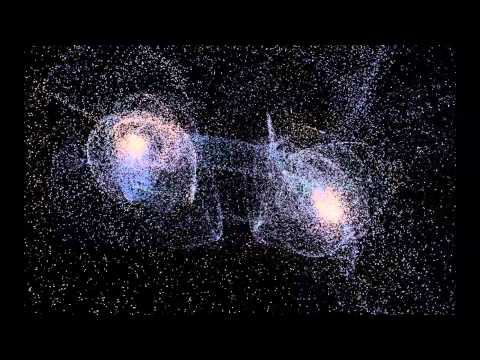

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("7HF5Oy8IMoM")

## Can we beat $\mathcal{O}(n^2)$?

- Generally speaking **NO**. 
- The point is that we have $\mathcal{O}(n^2)$ input data, so there is no way to be faster for a general matrix.
- Fortunately, we can be faster <font color='red'>for certain types of matrices</font>.
Here are some examples:

    * The simplest example may be a matrix of all ones, which can be easily multiplied with only $n-1$ additions. This matrix is of rank one. More generally we can multiply fast by <font color='red'>low-rank </font> matrices (or by matrices that have low-rank blocks)

    * <font color='red'>Sparse</font> matrices (contain $\mathcal{O}(n)$ nonzero elements)

    * <font color='red'>Structured</font> matrices:
      * Fourier
      * Circulant
      * Toeplitz 
      * Hankel

## Matrix-by-matrix product

Consider composition of two linear operators:

1. $y = Bx$
2. $z = Ay$

Then, $z = Ay =  A B x = C x$, where $C$ is the **matrix-by-matrix product**.

## Matrix-by-matrix product (MM): classics

**Definition**. A product of an $n \times k$ matrix $A$ and a $k \times m$ matrix $B$ is a $n \times m$ matrix $C$ with the elements  
$$
   c_{ij} = \sum_{s=1}^k a_{is} b_{sj}, \quad i = 1, \ldots, n, \quad j = 1, \ldots, m 
$$

For $m=k=n$ complexity of a na&iuml;ve algorithm is $2n^3 - n^2 =$ <font color='red'>$\mathcal{O}(n^3)$</font>.   

## Discussion of MM

- Matrix-by-matrix product is the **core** for almost all efficient algorithms in numerical linear algebra.  

- Basically, all the dense NLA algorithms are reduced to a sequence of matrix-by-matrix products.

- Efficient implementation of MM reduces the complexity of numerical algorithms by the same factor.  

- However, implementing MM is not easy at all!

## Efficient implementation for MM
**Q1**: Is it easy to multiply a matrix by a matrix in the most efficient way?

## Answer: no, it is not easy

If you want it as fast as possible, using the computers that are at hand.

## Demo
Let us do a short demo and compare a `np.dot()` procedure which in my case uses MKL with a hand-written matrix-by-matrix routine in Python and also its numba version.

In [1]:
import numpy as np
def matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]  
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
                
    return c

In [2]:
import numpy as np
from numba import jit # Just-in-time compiler for Python, see http://numba.pydata.org 

@jit(nopython=True)
def numba_matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
    return c

Then we just compare computational times.

Guess the answer.

In [6]:
import jax.numpy as jnp
n = 100
a = np.random.randn(n, n)
b = np.random.randn(n, n)

a_jax = jnp.array(a)
b_jax = jnp.array(b)

%timeit matmul(a, b)
%timeit numba_matmul(a, b)
%timeit a @ b
%timeit (a_jax @ b_jax).block_until_ready()

689 ms ± 5.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.02 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.5 µs ± 993 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
151 µs ± 1.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Is this answer correct for any dimensions of matrices?

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

dim_range = [10*i for i in range(1, 11)]
time_range_matmul = []
time_range_numba_matmul = []
time_range_np = []
for n in dim_range:
    print("Dimension = {}".format(n))
    a = np.random.randn(n, n)
    b = np.random.randn(n, n)

    t = %timeit -o -q matmul(a, b)
    time_range_matmul.append(t.average)
    t = %timeit -o -q numba_matmul(a, b)
    time_range_numba_matmul.append(t.average)
    t = %timeit -o -q np.dot(a, b)
    time_range_np.append(t.average)

Dimension = 10
Dimension = 20
Dimension = 30
Dimension = 40
Dimension = 50
Dimension = 60
Dimension = 70
Dimension = 80
Dimension = 90
Dimension = 100


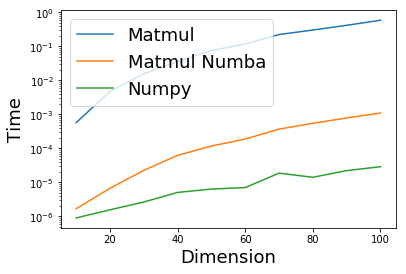

In [6]:
plt.plot(dim_range, time_range_matmul, label="Matmul")
plt.plot(dim_range, time_range_numba_matmul, label="Matmul Numba")
plt.plot(dim_range, time_range_np, label="Numpy")
plt.legend(fontsize=18)
plt.xlabel("Dimension", fontsize=18)
plt.ylabel("Time", fontsize=18)
plt.yscale("log")

## Why is na&iuml;ve implementation slow?
It is slow due to two issues:

- It does not use the benefits of fast memory (cache) and in general memory architecture
- It does not use available parallelization ability (especially important for GPU) 

## Memory architecture
<img width=80% src="Memory-Hierarchy.jpg">

- Fast memory is small
- Bigger memory is slow

## Making algorithms more computationally intensive 

<font color='red'>**Implementation in NLA**</font>: use block version of algorithms. <br>

This approach is a core of **[BLAS (Basic Linear Algebra Subroutines)](http://www.netlib.org/blas/)**, written in Fortran many years ago, and still rules the computational world.

Split the matrix into blocks! For illustration consider splitting in $2 \times 2$ block matrix:

$$
   A = \begin{bmatrix}
         A_{11} & A_{12} \\
         A_{21} & A_{22}
        \end{bmatrix}, \quad B = \begin{bmatrix}
         B_{11} & B_{12} \\
         B_{21} & B_{22}
        \end{bmatrix}$$

Then,  

$$AB = \begin{bmatrix}A_{11} B_{11} + A_{12} B_{21} & A_{11} B_{12} + A_{12} B_{22} \\
            A_{21} B_{11} + A_{22} B_{21} & A_{21} B_{12} + A_{22} B_{22}\end{bmatrix}.$$  

If $A_{11}, B_{11}$ and their product fit into the cache memory (which is 12 Mb (L3) for the [recent Intel Chip](https://en.wikipedia.org/wiki/List_of_Intel_microprocessors#Desktop)), then we load them only once into the memory.  

## BLAS
BLAS has three levels:
1. BLAS-1, operations like $c = a + b$
2. BLAS-2, operations like matrix-by-vector product
3. BLAS-3, matrix-by-matrix product

What is the principal differences between them?

The main difference is the number of operations vs. the number of input data!

1. BLAS-1: $\mathcal{O}(n)$ data, $\mathcal{O}(n)$ operations
2. BLAS-2: $\mathcal{O}(n^2)$ data, $\mathcal{O}(n^2)$ operations
3. BLAS-3: $\mathcal{O}(n^2)$ data, $\mathcal{O}(n^3)$ operations

## Why BLAS is so important and actual?

1. The state-of-the-art implementation of the basic linear algebra operations
2. Provides standard names for operations in any new implementations (e.g. [ATLAS](https://www.netlib.org/atlas/), [OpenBLAS](https://www.openblas.net/), [MKL](https://software.intel.com/en-us/mkl)). You can call matrix-by-matrix multiplication function (GEMM), link your code with any BLAS implementation and it will work correctly
3. Formulate new algorithms in terms of BLAS operations
4. There are wrappers for the most popular languages

## Packages related to BLAS

1. [ATLAS](http://math-atlas.sourceforge.net) - Automatic Tuned Linear Algebra Software. It automatically adapts to a particular system architechture. 
2. [LAPACK](http://www.netlib.org/lapack/) - Linear Algebra Package. It provides high-level linear algebra operations (e.g. matrix factorizations), which are based on calls of BLAS subroutines.
3. [Intel MKL](https://software.intel.com/en-us/intel-mkl) - Math Kernel Library. It provides re-implementation of BLAS and LAPACK, optimized for Intel processors. Available in Anaconda Python distribution: 
```
conda install mkl
```
MATLAB uses Intel MKL by default.

4. OpenBLAS is an optimized BLAS library based on [GotoBLAS](https://en.wikipedia.org/wiki/GotoBLAS). 

5. PyTorch [supports](https://pytorch.org/docs/stable/torch.html#blas-and-lapack-operations) some calls from BLAS and LAPACK

6. For GPU it was implemented special [cuBLAS](https://docs.nvidia.com/cuda/cublas/index.html).


For comparison of OpenBLAS and Intel MKL, see this [review](https://software.intel.com/en-us/articles/performance-comparison-of-openblas-and-intel-math-kernel-library-in-r)



## Faster algorithms for matrix multiplication

Recall that matrix-matrix multiplication costs $\mathcal{O}(n^3)$ operations.
However, storage is $\mathcal{O}(n^2)$.

**Question:** is it possible to reduce number operations down to $\mathcal{O}(n^2)$?

**Answer**: a quest for $\mathcal{O}(n^2)$ matrix-by-matrix multiplication algorithm is not yet done.

* Strassen gives $\mathcal{O}(n^{2.807\dots})$ –– sometimes used in practice 

* [Current world record](http://arxiv.org/pdf/1401.7714v1.pdf) $\mathcal{O}(n^{2.37\dots})$ –– big constant, not practical, based on [Coppersmith-Winograd_algorithm](https://en.wikipedia.org/wiki/Coppersmith%E2%80%93Winograd_algorithm).
- It improved the previous record (Williams 2012) by $3\cdot 10^{-7}$
- The papers still study multiplication of $3 \times 3$ matrices and interpret it from different sides ([Heule, et. al. 2019](https://arxiv.org/pdf/1905.10192.pdf)) 

Consider Strassen in more details. 

## Na&iuml;ve multiplication

Let $A$ and $B$ be two $2\times 2$ matrices. Na&iuml;ve multiplication $C = AB$

$$
\begin{bmatrix} c_{11} & c_{12} \\ c_{21} & c_{22}  \end{bmatrix}  =
\begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22}  \end{bmatrix}
\begin{bmatrix} b_{11} & b_{12} \\ b_{21} & b_{22}  \end{bmatrix} =
\begin{bmatrix} 
a_{11}b_{11} + a_{12}b_{21} & a_{11}b_{21} + a_{12}b_{22} \\ 
a_{21}b_{11} + a_{22}b_{21} & a_{21}b_{21} + a_{22}b_{22} 
\end{bmatrix}
$$

contains $8$ multiplications and $4$ additions.

## Strassen algorithm

In the work [Gaussian elimination is not optimal](http://link.springer.com/article/10.1007%2FBF02165411?LI=true) (1969) Strassen found that one can calculate $C$ using 18 additions and only 7 multiplications:
$$
\begin{split}
c_{11} &= f_1 + f_4 - f_5 + f_7, \\
c_{12} &= f_3 + f_5, \\
c_{21} &= f_2 + f_4, \\
c_{22} &= f_1 - f_2 + f_3 + f_6,
\end{split}
$$
where
$$
\begin{split}
f_1 &= (a_{11} + a_{22}) (b_{11} + b_{22}), \\
f_2 &= (a_{21} + a_{22}) b_{11}, \\
f_3 &= a_{11} (b_{12} - b_{22}), \\
f_4 &= a_{22} (b_{21} - b_{11}), \\
f_5 &= (a_{11} + a_{12}) b_{22}, \\
f_6 &= (a_{21} - a_{11}) (b_{11} + b_{12}), \\
f_7 &= (a_{12} - a_{22}) (b_{21} + b_{22}).
\end{split}
$$

Fortunately, these formulas hold even if $a_{ij}$ and $b_{ij}$, $i,j=1,2$ are block matrices.

Thus, Strassen algorithm looks as follows. 
- First of all we <font color='red'>split</font> matrices $A$ and $B$ of sizes $n\times n$, $n=2^d$ <font color='red'> into 4 blocks</font> of size $\frac{n}{2}\times \frac{n}{2}$
- Then we <font color='red'>calculate multiplications</font> in the described formulas <font color='red'>recursively</font>

This leads us again to the **divide and conquer** idea.

## Complexity of the Strassen algorithm

#### Number of multiplications

Calculation of number of multiplications is a trivial task. Let us denote by $M(n)$ number of multiplications used to multiply 2 matrices of sizes $n\times n$ using the divide and conquer concept.
Then for na&iuml;ve algorithm we have number of multiplications

$$ M_\text{naive}(n) = 8 M_\text{naive}\left(\frac{n}{2} \right) = 8^2 M_\text{naive}\left(\frac{n}{4} \right)
= \dots = 8^{d-1} M(1) = 8^{d} = 8^{\log_2 n} = n^{\log_2 8} = n^3 $$

So, even when using divide and coquer idea we can not be better than $n^3$.

Let us calculate number of multiplications for the Strassen algorithm:

$$ M_\text{strassen}(n) = 7 M_\text{strassen}\left(\frac{n}{2} \right) = 7^2 M_\text{strassen}\left(\frac{n}{4} \right)
= \dots = 7^{d-1} M(1) = 7^{d} = 7^{\log_2 n} = n^{\log_2 7} $$

#### Number of additions

There is no point to estimate number of addtitions $A(n)$ for naive algorithm, as we already got $n^3$ multiplications.  
For the Strassen algorithm we have:

$$ A_\text{strassen}(n) = 7 A_\text{strassen}\left( \frac{n}{2} \right) + 18 \left( \frac{n}{2} \right)^2 $$

since on the first level we have to add $\frac{n}{2}\times \frac{n}{2}$ matrices 18 times and then go deeper for each of the 7 multiplications. Thus,

<font size=2.0>

$$ \begin{split}
A_\text{strassen}(n) =& 7 A_\text{strassen}\left( \frac{n}{2} \right) + 18 \left( \frac{n}{2} \right)^2 = 7 \left(7 A_\text{strassen}\left( \frac{n}{4} \right) + 18 \left( \frac{n}{4} \right)^2 \right) + 18 \left( \frac{n}{2} \right)^2 =
7^2 A_\text{strassen}\left( \frac{n}{4} \right) + 7\cdot 18 \left( \frac{n}{4} \right)^2 +  18 \left( \frac{n}{2} \right)^2 = \\
=& \dots = 18 \sum_{k=1}^d 7^{k-1} \left( \frac{n}{2^k} \right)^2 = \frac{18}{4} n^2 \sum_{k=1}^d \left(\frac{7}{4} \right)^{k-1} = \frac{18}{4} n^2 \frac{\left(\frac{7}{4} \right)^d - 1}{\frac{7}{4} - 1} = 6 n^2 \left( \left(\frac{7}{4} \right)^d - 1\right) \leqslant 6 n^2 \left(\frac{7}{4} \right)^d = 6 n^{\log_2 7}
\end{split}
$$
</font>

(since $4^d = n^2$ and $7^d = n^{\log_2 7}$).


Asymptotic behavior of $A(n)$ could be also found from the [master theorem](https://en.wikipedia.org/wiki/Master_theorem).

#### Total complexity

Total complexity is $M_\text{strassen}(n) + A_\text{strassen}(n)=$ <font color='red'>$7 n^{\log_2 7}$</font>. Strassen algorithm becomes faster
when

\begin{align*}
2n^3 &> 7 n^{\log_2 7}, \\
n &> 667,
\end{align*}

so it is not a good idea to get to the bottom level of recursion.

## Strassen algorithm reloaded

- Recent paper [Strassen algorithm reloaded](http://jianyuhuang.com/papers/sc16.pdf)
claim to **break conventional wisdom** that Strassen algorithm is not very practical.

- Conventional wisdom: it is only
 practical for very large matrices. The proposed implementation is practical
 for small matrices. 
- Conventional wisdom: the matrices being
 multiplied should be relatively square. The proposed implementation is
 practical for rank-$k$ updates, where $k$ is relatively small (a shape
 of importance for libraries like LAPACK). 
- Conventional wisdom:
  it inherently requires substantial workspace. The proposed implementation
  requires no workspace beyond buffers already incorporated
  into conventional high-performance DGEMM implementations.
- Conventional wisdom: a Strassen DGEMM interface must pass
 in workspace. The proposed implementation requires no such workspace
 and can be plug-compatible with the standard DGEMM interface.
- Conventional wisdom: it is hard to demonstrate speedup
 on multi-core architectures. The proposed implementation demonstrates
 speedup over conventional DGEMM even on an IntelR Xeon
 PhiTM coprocessor utilizing 240 threads. It is shown how a distributed
 memory matrix-matrix multiplication also benefits from
 these advances.

## Strassen algorithm and tensor rank (advanced topic)

- It is not clear how Strassen found these formulas. 
- However, now we can see that they are not artificial.
- There is a general approach based on the so-called tensor decomposition technique. 
- Here by tensor we imply a multidimensional array - generalization of the matrix concept to many dimensions.

Let us enumerate elements in the $2\times 2$ matrices as follows

$$
\begin{bmatrix} c_{1} & c_{3} \\ c_{2} & c_{4}  \end{bmatrix} =
\begin{bmatrix} a_{1} & a_{3} \\ a_{2} & a_{4}  \end{bmatrix}
\begin{bmatrix} b_{1} & b_{3} \\ b_{2} & b_{4}  \end{bmatrix}=
\begin{bmatrix} 
a_{1}b_{1} + a_{3}b_{2} & a_{1}b_{3} + a_{3}b_{4} \\ 
a_{2}b_{1} + a_{4}b_{2} & a_{2}b_{3} + a_{4}b_{4} 
\end{bmatrix}
$$

This can be written as

$$ c_k = \sum_{i=1}^4 \sum_{j=1}^4 x_{ijk} a_i b_j, \quad k=1,2,3,4 $$

$x_{ijk}$ is a 3-dimensional array, that consists of zeros and ones:

$$
\begin{split}
x_{\ :,\ :,\ 1} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\quad
x_{\ :,\ :,\ 2} = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{pmatrix} \\
x_{\ :,\ :,\ 3} = 
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\quad
x_{\ :,\ :,\ 4} = 
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{split}
$$



#### Trilinear decomposition

To get Strassen algorithm we should do the following trick –– decompose $x_{ijk}$ in the following way

$$ x_{ijk} = \sum_{\alpha=1}^r u_{i\alpha} v_{j\alpha} w_{k\alpha}. $$

This decomposition is called **trilinear tensor decomposition** and has a meaning of separation of variables: we have a sum of $r$ (called rank) summands with separated $i$, $j$ and $k$.

#### Strassen via trilinear

Now we have

$$ c_k = \sum_{\alpha=1}^r w_{k\alpha} \left(\sum_{i=1}^4  u_{i\alpha} a_i \right) \left( \sum_{j=1}^4 v_{j\alpha} b_j\right), \quad k=1,2,3,4. $$

Multiplications by $u_{i\alpha}$ or $v_{j\alpha}$ or $w_{k\alpha}$ do not require recursion since $u, v$ and $w$ are known precomputed matrices. Therefore, we have only $r$ multiplications of $\left(\sum_{i=1}^4  u_{i\alpha} a_i \right)$ $\left( \sum_{j=1}^4 v_{j\alpha} b_j\right)$ where both factors depend on the input data.
 
As you might guess array $x_{ijk}$ has rank $r=7$, which leads us to $7$ multiplications and to the Strassen algorithm!

## Summary of MM part
- MM is the core of NLA. You have to think in block terms, if you want high efficiency
- This is all about computer memory hierarchy
- Concept of block algorithms
- (Advanced topic) Strassen and trilinear form

In [8]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()